In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

/Users/tangweiye/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# load dataset
data = pd.read_csv('../../datas/dataKmeanSampleOversampling.csv')

In [3]:
# get label = 7 (normal)
normal_data = data[data['Attack_type'] == 7]
anomaly_data = data[data['Attack_type'] != 7]

In [4]:
normal_data

,Unnamed: 0,arp.opcode,arp.hw.size,icmp.checksum,icmp.seq_le,icmp.unused,http.content_length,http.response,http.tls_port,tcp.ack,...,mqtt.conack.flags-1471199,mqtt.conack.flags-1574358,mqtt.conack.flags-1574359,mqtt.protoname-0,mqtt.protoname-0.0,mqtt.protoname-MQTT,mqtt.topic-0,mqtt.topic-0.0,mqtt.topic-Temperature_and_Humidity,Attack_type
0,991139,-0.003437,-0.003618,-0.166331,-0.179964,0.0,-0.053767,-0.131792,0.0,-0.149153,...,0,0,0,1,0,0,1,0,0,7
1,988981,-0.003437,-0.003618,-0.166331,-0.179964,0.0,-0.053767,-0.131792,0.0,-0.149152,...,0,0,0,1,0,0,1,0,0,7
2,991901,-0.003437,-0.003618,-0.166331,-0.179964,0.0,-0.053767,-0.131792,0.0,-0.149153,...,0,0,0,1,0,0,0,0,1,7
3,996352,-0.003437,-0.003618,-0.166331,-0.179964,0.0,-0.053767,-0.131792,0.0,-0.149153,...,0,0,0,1,0,0,1,0,0,7
4,991504,-0.003437,-0.003618,-0.166331,-0.179964,0.0,-0.053767,-0.131792,0.0,-0.149153,...,0,0,0,1,0,0,1,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154299,741571,-0.003437,-0.003618,-0.166331,-0.179964,0.0,-0.053767,-0.131792,0.0,-0.144682,...,0,0,0,1,0,0,1,0,0,7
154300,741118,-0.003437,-0.003618,-0.166331,-0.179964,0.0,-0.053767,-0.131792,0.0,1.013944,...,0,0,0,1,0,0,1,0,0,7
154301,751189,-0.003437,-0.003618,-0.166331,-0.179964,0.0,-0.053767,-0.131792,0.0,-0.149152,...,0,0,0,1,0,0,1,0,0,7
154302,736738,-0.003437,-0.003618,-0.166331,-0.179964,0.0,-0.053767,-0.131792,0.0,-0.144871,...,0,0,0,1,0,0,1,0,0,7


In [5]:
# count number of normal data
print('Number of normal data: ', len(normal_data))
print('Number of anomaly data: ', len(anomaly_data))

Number of normal data:  10909
Number of anomaly data:  152776


In [6]:
delta_len = len(anomaly_data)-int(0.8*len(normal_data))
len_sub_anomaly_data = len(anomaly_data) - delta_len        
anomaly_data = anomaly_data.sample(len_sub_anomaly_data)
print('Number of anomaly data after cutting: ', len(anomaly_data))

Number of anomaly data after cutting:  8727


In [7]:
# cut 0.2 of normal data to anomaly data
subset = normal_data.loc[normal_data['Attack_type'] == 7].sample(frac=0.2)
anomaly_data = anomaly_data.append(subset)
normal_data = normal_data.drop(subset.index)

/var/folders/bb/4xpzjsw5339b418xg5qk5r100000gn/T/ipykernel_54975/2589865491.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  anomaly_data = anomaly_data.append(subset)


In [8]:
print('Number of normal data: ', len(normal_data))
print('Number of anomaly data: ', len(anomaly_data))

Number of normal data:  8727
Number of anomaly data:  10909


In [9]:
# shuffle anomaly data
anomaly_data = anomaly_data.sample(frac=1)

In [10]:
# split label each set
train_label = normal_data['Attack_type']
train_data = normal_data.drop(columns=['Attack_type'])

test_label = anomaly_data['Attack_type']
test_data = anomaly_data.drop(columns=['Attack_type'])

In [11]:
train_data = train_data.to_numpy()
test_data = test_data.to_numpy()

## define model

In [12]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, use_bias=False, input_shape=(97,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(512, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(97, activation='tanh'))

    return model

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, use_bias=False, input_shape=(97,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(128, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(64, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [14]:
# define loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [15]:
# give optimizer for each model
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


2023-10-20 17:16:27.133671: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-20 17:16:27.133870: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [16]:
discriminator = make_discriminator_model()
discriminator.compile(optimizer=discriminator_optimizer, loss=discriminator_loss,metrics=['accuracy'])

In [17]:
generator = make_generator_model()

In [18]:
# test generator to create fake data
noise = tf.random.normal([1, 97])
generated_data = generator(noise, training=False)
print(generated_data)

tf.Tensor(
[[ 4.2549339e-01 -5.0255823e-01 -5.0837800e-02 -3.4087848e-02
   6.7557740e-01 -1.1204537e-01 -7.4137352e-02  2.6904771e-01
   5.0247904e-02 -4.0763091e-02 -7.7002399e-02 -2.2087079e-01
   8.6712882e-02  3.6337560e-01  3.9768460e-01 -2.8324592e-01
  -2.0213504e-01  3.0058661e-02  5.1220733e-01  7.5105414e-02
   5.4533118e-01 -4.3348658e-01  1.4167351e-01  1.6721730e-01
  -2.1400031e-01  3.0251825e-01 -5.2764541e-01  1.4804603e-01
  -2.1683757e-01 -2.2347558e-01  1.3800560e-01 -2.6344073e-01
  -4.6401942e-01 -1.2847063e-01  1.2795618e-01 -8.4006339e-02
  -3.0837227e-02  2.1761365e-01  1.1026882e-01  8.1228845e-02
  -3.0689448e-02  6.2822536e-02 -2.5891629e-01  2.0184121e-01
  -4.2649060e-02 -1.4072286e-02  3.0910176e-01 -3.3390248e-01
  -2.0036790e-01 -3.2129723e-01  3.3188343e-01 -4.8805976e-01
  -6.5980695e-02 -3.0407754e-01  3.0871779e-01  1.5848143e-01
  -4.5903325e-01 -3.3343580e-01  1.2093038e-01  6.5420410e-03
   1.4104423e-01 -1.5693241e-01 -1.5594259e-02 -5.2281735e-

In [19]:
# train discriminator
EPOCHS = 10
noise_dim = 97
num_examples_to_generate = train_data.shape[0]


def train_step(data):
    threshold = None
    noise = tf.random.normal([num_examples_to_generate, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)

        real_output = discriminator(data, training=True)
        fake_output = discriminator(generated_data, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    if threshold is None:
        threshold = tf.reduce_mean(real_output).numpy()
    return threshold



def train(dataset, epochs):
    for epoch in range(epochs):
        threshold = train_step(dataset)
        if epoch % 10 == 0:
            print('Epoch: ', epoch)
    return threshold


In [20]:
def test(data, threshold):
    # if greater than threshold, it is normal
    # if less than threshold, it is anomaly
    output = discriminator(data, training=False)
    # if output > threshold: give 1 else 0
    output = np.where(output > threshold, 1, 0)
    return output


In [21]:
def evaluation(validate_data, output):
    # draw a confusion matrix
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from sklearn.metrics import accuracy_score
    # use plot confusion matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    

    cm = confusion_matrix(validate_data, output)
    print(cm)
    print(classification_report(validate_data, output))
    print(accuracy_score(validate_data, output))
    
    
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='.20g', cmap='Blues')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.figure(figsize=(20, 20), dpi=100)
    ax.xaxis.set_ticklabels(['Anomaly', 'Normal'])
    ax.yaxis.set_ticklabels(['Anomaly', 'Normal'])
    plt.show()

        

In [22]:
# train model and get threshold
threshold = train(train_data, EPOCHS)
print('threshold: ', threshold)
# test discriminator
output = test(test_data, threshold)
print(output)


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x8727x1x256xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x8727x1x128xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerfo

Epoch:  0
threshold:  0.5866879
[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]


In [23]:
test_label = np.where(test_label == 7, 1, 0)

[[   0 8727]
 [ 382 1800]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8727
           1       0.17      0.82      0.28      2182

    accuracy                           0.17     10909
   macro avg       0.09      0.41      0.14     10909
weighted avg       0.03      0.17      0.06     10909

0.16500137501145842


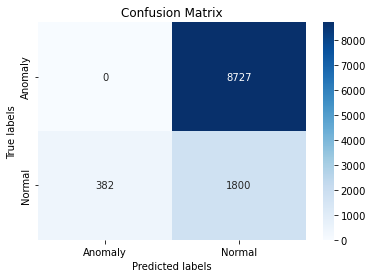

<Figure size 2000x2000 with 0 Axes>

In [24]:
evaluation(test_label, output)

## use pure ANN model

In [25]:
def ann_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, use_bias=False, input_shape=(97,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(128, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(64, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [26]:
ann = ann_model()
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann.fit(train_data, train_label, epochs=10)
ann.evaluate(test_data, test_label)

Epoch 1/10


2023-10-20 17:16:44.213556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x256xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x128xi1>'

272/273 [============================>.] - ETA: 0s - loss: -65.1451 - accuracy: 0.0000e+00

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x23x1x256xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x23x1x128xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforman

273/273 [==============================] - 18s 36ms/step - loss: -65.3744 - accuracy: 0.0000e+00
Epoch 2/10
273/273 [==============================] - 5s 18ms/step - loss: -300.9055 - accuracy: 0.0000e+00
Epoch 3/10
273/273 [==============================] - 5s 18ms/step - loss: -711.9995 - accuracy: 0.0000e+00
Epoch 4/10
273/273 [==============================] - 5s 19ms/step - loss: -1285.5211 - accuracy: 0.0000e+00
Epoch 5/10
273/273 [==============================] - 5s 19ms/step - loss: -2008.1432 - accuracy: 0.0000e+00
Epoch 6/10
273/273 [==============================] - 5s 18ms/step - loss: -2869.5127 - accuracy: 0.0000e+00
Epoch 7/10
273/273 [==============================] - 5s 18ms/step - loss: -3859.6865 - accuracy: 0.0000e+00
Epoch 8/10
273/273 [==============================] - 5s 18ms/step - loss: -4975.0635 - accuracy: 0.0000e+00
Epoch 9/10
273/273 [==============================] - 5s 19ms/step - loss: -6204.3433 - accuracy: 0.0000e+00
Epoch 10/10
273/273 [============

KeyboardInterrupt: 